In [68]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

In [69]:
# --- 1) input file paths (update if needed) ---
airports_fp = "Data/Flight routes Data/airports.dat"
routes_fp   = "Data/Flight routes Data/routes.dat"
shipping_geojson = "Data/Shipping-Lanes data/Shipping_Lanes_v1.geojson"
shipping_shp = "Data/Shipping-Lanes data/Shipping-Lanes-v1/Shipping-Lanes-v1.shp"

In [70]:
# --- 2) read airports (same as your code) ---
airports = pd.read_csv(
    airports_fp, delimiter=',',
    names=['id', 'name', 'city', 'country', 'iata',
           'icao', 'lat', 'long', 'altitude', 'timezone',
           'dst', 'tz', 'type', 'source'],
    dtype=str,  # read as string first to avoid unexpected type casts
)
airports.head()

,id,name,city,country,iata,icao,lat,long,altitude,timezone,dst,tz,type,source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081689834590001,145.391998291,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.20707988739,145.789001465,20,10,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826789855957031,144.29600524902344,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380355834961,147.22000122070312,146,10,U,Pacific/Port_Moresby,airport,OurAirports


In [71]:
# cast numeric coords
airports['lat'] = pd.to_numeric(airports['lat'], errors='coerce')
airports['long'] = pd.to_numeric(airports['long'], errors='coerce')
airports.head()

,id,name,city,country,iata,icao,lat,long,altitude,timezone,dst,tz,type,source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports


<function matplotlib.pyplot.show(close=None, block=None)>

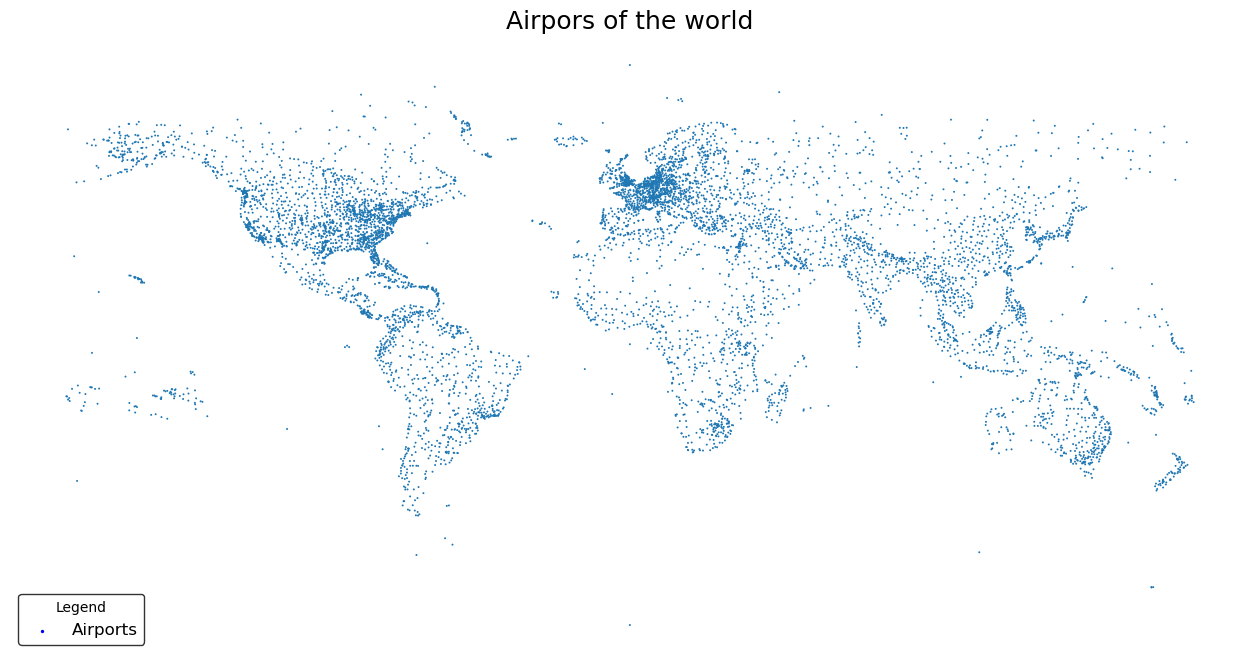

In [106]:
fig, ax = plt.subplots(figsize = (16,8))

ax.scatter(airports['long'], airports['lat'], s=2, alpha=1, edgecolors='none')

# Add legend: create a dummy point
ax.scatter([], [], s=2, color='blue', label='Airports')  # invisible point for legend
ax.legend(loc='lower left', fontsize=12, facecolor='white', edgecolor='black', title='Legend')

ax.axis('off')
ax.set_title("Airpors of the world", fontsize = 18)

#plt.savefig("Airports of the world.png", dpi=300, bbox_inches='tight')
plt.show

In [73]:
# --- 3) read routes and attach coordinates (same logic) ---
routes = pd.read_csv(
    routes_fp, delimiter=',', header=None,
    names=['airline', 'id', 'source_airport', 'source_airport_id',
           'destination_airport', 'destination_airport_id', 'codeshare',
           'stops', 'equipment'],
    dtype=str
)

routes.head()

,airline,id,source_airport,source_airport_id,destination_airport,destination_airport_id,codeshare,stops,equipment
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2


In [74]:
# Keep only necessary columns
routes = routes[['source_airport', 'destination_airport']].dropna()

routes.head()

,source_airport,destination_airport
0,AER,KZN
1,ASF,KZN
2,ASF,MRV
3,CEK,KZN
4,CEK,OVB


In [75]:
# Prepare lookups for coords
src_df = airports[['name','iata','icao','lat','long']].copy()
dst_df = src_df.copy()
src_df.columns = [c + '_source' for c in src_df.columns]
dst_df.columns = [c + '_destination' for c in dst_df.columns]

routes = pd.merge(routes, src_df, left_on='source_airport', right_on='iata_source', how='left')
routes = pd.merge(routes, dst_df, left_on='destination_airport', right_on='iata_destination', how='left')

# Drop any routes without coordinate for either end
routes = routes.dropna(subset=['lat_source','long_source','lat_destination','long_destination'])

routes.head()

,source_airport,destination_airport,name_source,iata_source,icao_source,lat_source,long_source,name_destination,iata_destination,icao_destination,lat_destination,long_destination
0,AER,KZN,Sochi International Airport,AER,URSS,43.449902,39.956600,Kazan International Airport,KZN,UWKD,55.606201,49.278702
1,ASF,KZN,Astrakhan Airport,ASF,URWA,46.283298,48.006302,Kazan International Airport,KZN,UWKD,55.606201,49.278702
2,ASF,MRV,Astrakhan Airport,ASF,URWA,46.283298,48.006302,Mineralnyye Vody Airport,MRV,URMM,44.225101,43.081902
3,CEK,KZN,Chelyabinsk Balandino Airport,CEK,USCC,55.305801,61.503300,Kazan International Airport,KZN,UWKD,55.606201,49.278702
4,CEK,OVB,Chelyabinsk Balandino Airport,CEK,USCC,55.305801,61.503300,Tolmachevo Airport,OVB,UNNT,55.012600,82.650703


In [76]:
# Build line geometries (lon, lat order)
geoms = [
    LineString([
        (float(routes.iloc[i]['long_source']), float(routes.iloc[i]['lat_source'])),
        (float(routes.iloc[i]['long_destination']), float(routes.iloc[i]['lat_destination']))
    ])
    for i in range(len(routes))
]
routes_gdf = gpd.GeoDataFrame(routes, geometry=geoms, crs="EPSG:4326")

routes_gdf.head()

,source_airport,destination_airport,name_source,iata_source,icao_source,lat_source,long_source,name_destination,iata_destination,icao_destination,lat_destination,long_destination,geometry
0,AER,KZN,Sochi International Airport,AER,URSS,43.449902,39.956600,Kazan International Airport,KZN,UWKD,55.606201,49.278702,"LINESTRING (39.9566 43.4499, 49.2787 55.6062)"
1,ASF,KZN,Astrakhan Airport,ASF,URWA,46.283298,48.006302,Kazan International Airport,KZN,UWKD,55.606201,49.278702,"LINESTRING (48.0063 46.2833, 49.2787 55.6062)"
2,ASF,MRV,Astrakhan Airport,ASF,URWA,46.283298,48.006302,Mineralnyye Vody Airport,MRV,URMM,44.225101,43.081902,"LINESTRING (48.0063 46.2833, 43.0819 44.2251)"
3,CEK,KZN,Chelyabinsk Balandino Airport,CEK,USCC,55.305801,61.503300,Kazan International Airport,KZN,UWKD,55.606201,49.278702,"LINESTRING (61.5033 55.3058, 49.2787 55.6062)"
4,CEK,OVB,Chelyabinsk Balandino Airport,CEK,USCC,55.305801,61.503300,Tolmachevo Airport,OVB,UNNT,55.012600,82.650703,"LINESTRING (61.5033 55.3058, 82.6507 55.0126)"


In [77]:
# Load shipping lanes
# -------------------
if os.path.exists(shipping_geojson):
    shipping = gpd.read_file(shipping_geojson)
elif os.path.exists(shipping_shp):
    shipping = gpd.read_file(shipping_shp)
else:
    raise FileNotFoundError("No shipping lanes file found.")

In [78]:
if shipping.crs is None:
    shipping = shipping.set_crs("EPSG:4326", allow_override=True)
elif shipping.crs.to_string() != "EPSG:4326":
    shipping = shipping.to_crs("EPSG:4326")

<GeoAxes: >

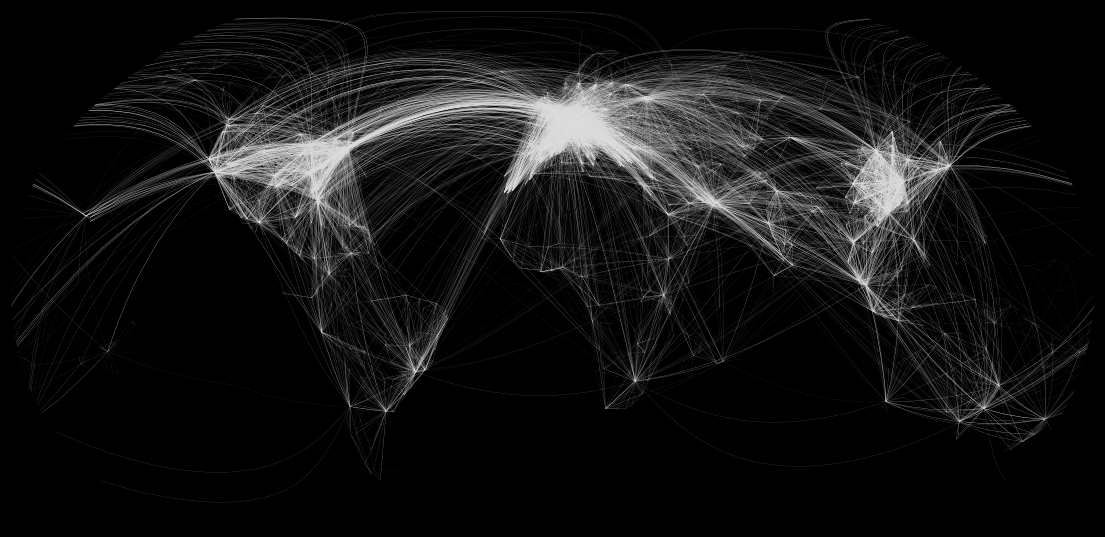

In [79]:
# Plot
# -------------------
fig, ax = plt.subplots(figsize=(14, 8),
                       subplot_kw={'projection': ccrs.Robinson()},
                       facecolor="black")

ax.set_facecolor("black")

# Plot flight routes
routes_gdf.plot(ax=ax, transform=ccrs.Geodetic(),
                color="white", linewidth=0.2, alpha=0.08, zorder=2)

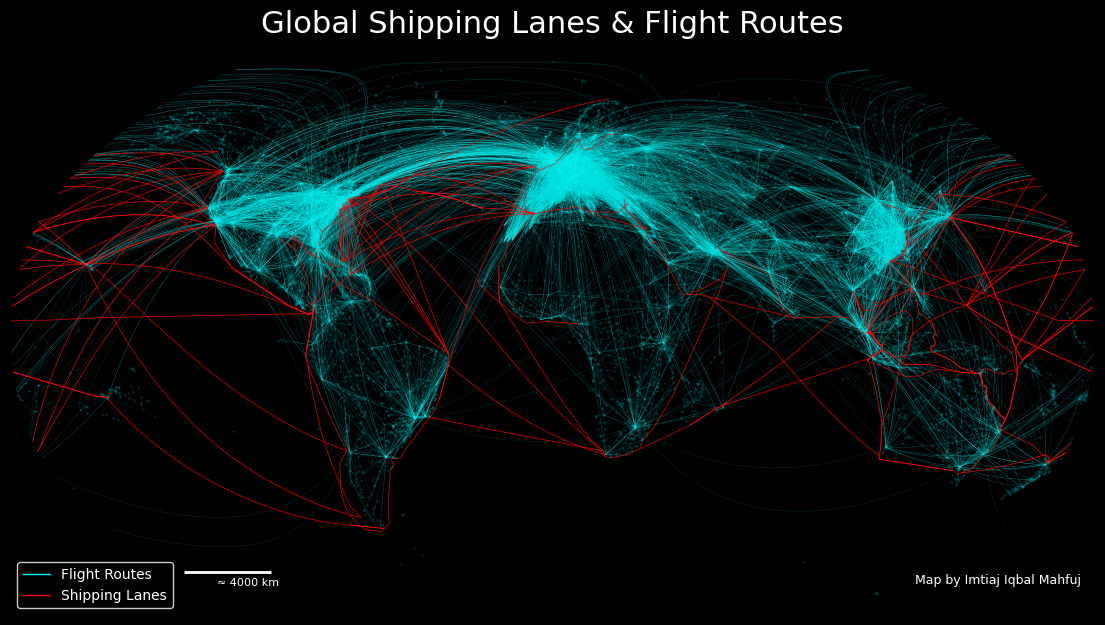

In [104]:
# Plot
# -------------------
fig, ax = plt.subplots(figsize=(14, 8),
                       subplot_kw={'projection': ccrs.Robinson()},
                       facecolor="black")

ax.set_facecolor("black")

# Plot flight routes
routes_gdf.plot(ax=ax, transform=ccrs.Geodetic(),
                color="cyan", linewidth=0.2, alpha=0.08, zorder=2)

# Plot shipping lanes
shipping.plot(ax=ax, transform=ccrs.PlateCarree(),
              color="red", linewidth=0.5, alpha=0.9, zorder=3)

# Plot airports
ax.scatter(airports['long'], airports['lat'],
           s=1, transform=ccrs.PlateCarree(),
           color="cyan", alpha=0.1, zorder=4)

# Legend
legend_handles = [
    Line2D([0], [0], color="cyan", lw=1, label="Flight Routes"),
    Line2D([0], [0], color="red", lw=1, label="Shipping Lanes")
]
legend = ax.legend(handles=legend_handles, loc="lower left",
                   fontsize=10, facecolor="black", edgecolor="white")

plt.setp(legend.get_texts(), color="white")

# Map elements
# -------------------

# Title
ax.set_title("Global Shipping Lanes & Flight Routes", fontsize=22, color="white", pad=20)

# Author credit
fig.text(0.89, 0.2, "Map by Imtiaj Iqbal Mahfuj", fontsize=9, color="white", ha="right", va="top")

# Simple scale bar (approximate, since Robinson is not equal-area)
scalebar_x = 0.1
scalebar_y = 0.05
ax.hlines(y=-70, xmin=-170, xmax=-130, colors="white", linewidth=2, transform=ccrs.PlateCarree())
ax.text(-150, -75, "≈ 4000 km", color="white", fontsize=8,
        ha="center", transform=ccrs.PlateCarree())

# Clean look
ax.set_global()
ax.set_xticks([]); ax.set_yticks([])

# Save
plt.savefig("Global_ShippingLanes_Flights.png", dpi=400,
            bbox_inches="tight", facecolor=fig.get_facecolor())
plt.show()

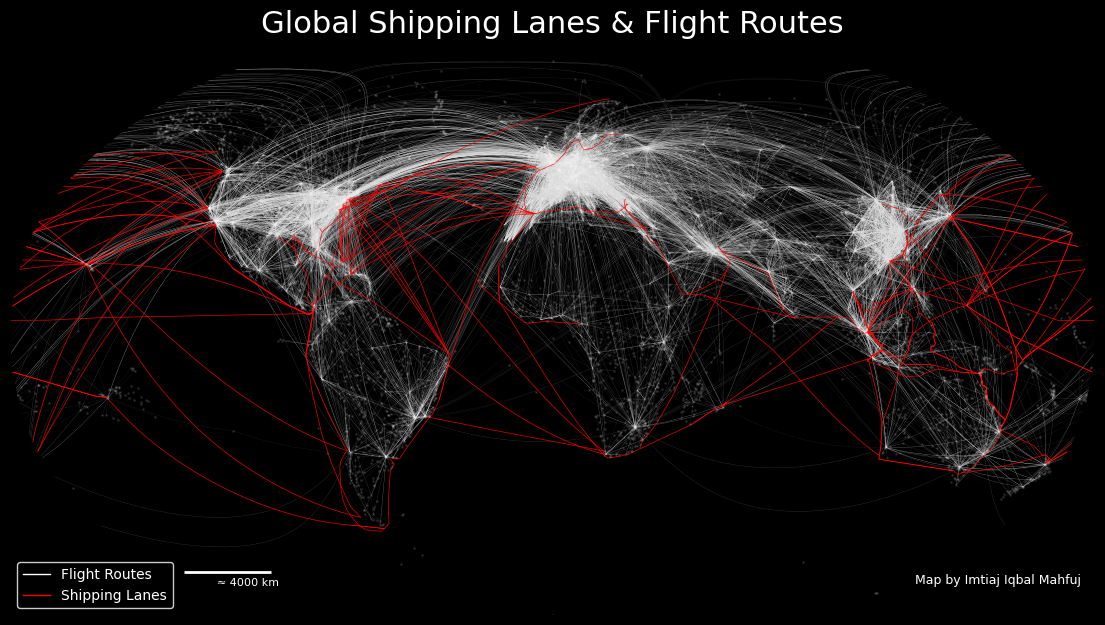

In [105]:
# Plot
# -------------------
fig, ax = plt.subplots(figsize=(14, 8),
                       subplot_kw={'projection': ccrs.Robinson()},
                       facecolor="black")

ax.set_facecolor("black")

# Plot flight routes
routes_gdf.plot(ax=ax, transform=ccrs.Geodetic(),
                color="white", linewidth=0.2, alpha=0.08, zorder=2)

# Plot shipping lanes
shipping.plot(ax=ax, transform=ccrs.PlateCarree(),
              color="red", linewidth=0.5, alpha=0.9, zorder=3)

# Plot airports
ax.scatter(airports['long'], airports['lat'],
           s=1, transform=ccrs.PlateCarree(),
           color="white", alpha=0.1, zorder=4)

# Legend
legend_handles = [
    Line2D([0], [0], color="white", lw=1, label="Flight Routes"),
    Line2D([0], [0], color="red", lw=1, label="Shipping Lanes")
]
legend = ax.legend(handles=legend_handles, loc="lower left",
                   fontsize=10, facecolor="black", edgecolor="white")

plt.setp(legend.get_texts(), color="white")

# Map elements
# -------------------

# Title
ax.set_title("Global Shipping Lanes & Flight Routes", fontsize=22, color="white", pad=20)

# Author credit
fig.text(0.89, 0.2, "Map by Imtiaj Iqbal Mahfuj", fontsize=9, color="white", ha="right", va="top")

# Simple scale bar (approximate, since Robinson is not equal-area)
scalebar_x = 0.1
scalebar_y = 0.05
ax.hlines(y=-70, xmin=-170, xmax=-130, colors="white", linewidth=2, transform=ccrs.PlateCarree())
ax.text(-150, -75, "≈ 4000 km", color="white", fontsize=8,
        ha="center", transform=ccrs.PlateCarree())

# Clean look
ax.set_global()
ax.set_xticks([]); ax.set_yticks([])

# Save
plt.savefig("Global_ShippingLanes_Flights_w.png", dpi=400,
            bbox_inches="tight", facecolor=fig.get_facecolor())
plt.show()